In [1]:
# Beijing air pollution dataset PM2.5 readings
# https://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data
# from UCI Machine Learning Repository
# NAs in the pm column are already removed from the dataset
# use TensorFlow 2.0 to build regression models

In [5]:
# import libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from utils import *
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, LambdaCallback

print('Libraries imported.')

Libraries imported.


In [6]:
# read in dataset
fulldf = pd.read_csv('BAQ.csv')
fulldf.head()

,obs,year,month,day,hour,dewpt,temp,press,cbwd,cws,hs,hr,pm
0,25,2010,1,2,0,-16,-4,1020,SE,1.79,0,0,129
1,26,2010,1,2,1,-15,-4,1020,SE,2.68,0,0,148
2,27,2010,1,2,2,-11,-5,1021,SE,3.57,0,0,159
3,28,2010,1,2,3,-7,-5,1022,SE,5.36,1,0,181
4,29,2010,1,2,4,-7,-5,1022,SE,6.25,2,0,138


In [10]:
# check data types
fulldf.dtypes

obs        int64
year       int64
month      int64
day        int64
hour       int64
dewpt      int64
temp       int64
press      int64
cbwd      object
cws      float64
hs         int64
hr         int64
pm         int64
dtype: object

In [7]:
# check for missing values
fulldf.isna().sum()

obs      0
year     0
month    0
day      0
hour     0
dewpt    0
temp     0
press    0
cbwd     0
cws      0
hs       0
hr       0
pm       0
dtype: int64

In [18]:
# day and year are unlikely to influence pm values
# but time(hour) and month could 
# observation number is also irrelevant

# remove unneeded columns an keep factors that might determine pm values
df = fulldf.drop(['obs', 'year', 'day'], axis = 1)
df.head()


,year,month,hour,dewpt,temp,press,cbwd,cws,hs,hr,pm
0,2010,1,0,-16,-4,1020,SE,1.79,0,0,129
1,2010,1,1,-15,-4,1020,SE,2.68,0,0,148
2,2010,1,2,-11,-5,1021,SE,3.57,0,0,159
3,2010,1,3,-7,-5,1022,SE,5.36,1,0,181
4,2010,1,4,-7,-5,1022,SE,6.25,2,0,138


In [12]:
# check unique values for cbwd (wind direction)
fulldf.cbwd.unique()

array(['SE', 'cv', 'NW', 'NE'], dtype=object)

In [14]:
# deal with cbwd (wind direction) column
# assign numeric values to wind direction
def cbwd_to_numeric(x):
    if x=='NE':
        return 1
    if x=='NW':
        return 2
    if x=='SE':
        return 3
    if x=='cv':
        return 4
    
fulldf['wd'] = fulldf['cbwd'].apply(cbwd_to_numeric)
fulldf.head()

,obs,year,month,day,hour,dewpt,temp,press,cbwd,cws,hs,hr,pm,wd
0,25,2010,1,2,0,-16,-4,1020,SE,1.79,0,0,129,3
1,26,2010,1,2,1,-15,-4,1020,SE,2.68,0,0,148,3
2,27,2010,1,2,2,-11,-5,1021,SE,3.57,0,0,159,3
3,28,2010,1,2,3,-7,-5,1022,SE,5.36,1,0,181,3
4,29,2010,1,2,4,-7,-5,1022,SE,6.25,2,0,138,3


In [15]:
# delete cbwd column
# move new wd (wind direction) column
del fulldf['cbwd']
temp = fulldf['wd']
fulldf.drop(labels=['wd'], axis=1, inplace = True)
fulldf.insert(8, 'wd', temp)
fulldf.head()

,obs,year,month,day,hour,dewpt,temp,press,wd,cws,hs,hr,pm
0,25,2010,1,2,0,-16,-4,1020,3,1.79,0,0,129
1,26,2010,1,2,1,-15,-4,1020,3,2.68,0,0,148
2,27,2010,1,2,2,-11,-5,1021,3,3.57,0,0,159
3,28,2010,1,2,3,-7,-5,1022,3,5.36,1,0,181
4,29,2010,1,2,4,-7,-5,1022,3,6.25,2,0,138


In [35]:
# normalize the full dataset
normdf = (fulldf - fulldf.mean()) / fulldf.std()
normdf.head()

,obs,year,month,day,hour,dewpt,temp,press,wd,cws,hs,hr,pm
0,-1.758104,-1.443338,-1.596248,-1.557732,-1.661020,-1.229777,-1.347127,0.345323,0.358837,-0.444939,-0.071056,-0.137407,0.330110
1,-1.758025,-1.443338,-1.596248,-1.557732,-1.516613,-1.160494,-1.347127,0.345323,0.358837,-0.427002,-0.071056,-0.137407,0.536519
2,-1.757946,-1.443338,-1.596248,-1.557732,-1.372205,-0.883364,-1.429261,0.442403,0.358837,-0.409064,-0.071056,-0.137407,0.656019
3,-1.757867,-1.443338,-1.596248,-1.557732,-1.227798,-0.606234,-1.429261,0.539483,0.358837,-0.372988,1.212847,-0.137407,0.895018
4,-1.757788,-1.443338,-1.596248,-1.557732,-1.083390,-0.606234,-1.429261,0.539483,0.358837,-0.355051,2.496751,-0.137407,0.427883


In [36]:
# isolate features
X = normdf.iloc[:, :12]
X.head()

,obs,year,month,day,hour,dewpt,temp,press,wd,cws,hs,hr
0,-1.758104,-1.443338,-1.596248,-1.557732,-1.661020,-1.229777,-1.347127,0.345323,0.358837,-0.444939,-0.071056,-0.137407
1,-1.758025,-1.443338,-1.596248,-1.557732,-1.516613,-1.160494,-1.347127,0.345323,0.358837,-0.427002,-0.071056,-0.137407
2,-1.757946,-1.443338,-1.596248,-1.557732,-1.372205,-0.883364,-1.429261,0.442403,0.358837,-0.409064,-0.071056,-0.137407
3,-1.757867,-1.443338,-1.596248,-1.557732,-1.227798,-0.606234,-1.429261,0.539483,0.358837,-0.372988,1.212847,-0.137407
4,-1.757788,-1.443338,-1.596248,-1.557732,-1.083390,-0.606234,-1.429261,0.539483,0.358837,-0.355051,2.496751,-0.137407


In [37]:
# isolate labels
Y = normdf.iloc[:, -1]
Y.head()

0    0.330110
1    0.536519
2    0.656019
3    0.895018
4    0.427883
Name: pm, dtype: float64

In [38]:
# evaluate shape of labels and features
X_arr = X.values
Y_arr = Y.values

print('X_arr shape: ', X_arr.shape)
print('Y_arr shape: ', Y_arr.shape)

X_arr shape:  (41757, 12)
Y_arr shape:  (41757,)


In [39]:
# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_arr, Y_arr, 
                                                    test_size = 0.3, 
                                                    shuffle = True, 
                                                    random_state=0)

print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('X_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (29229, 12)
y_train shape:  (29229,)
X_test shape:  (12528, 12)
y_test shape:  (12528,)


In [40]:
# define the model with 3 layers
def get_model():
    
    model = Sequential([
        Dense(25, input_shape = (12,), activation = 'relu'),
        Dense(50, activation = 'relu'),
        Dense(25, activation = 'relu'),
        Dense(1)
    ])

    model.compile(
        loss='mse',
        optimizer='adam'
    )
    
    return model

# can also try adadelta optimizer

model = get_model()
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 25)                325       
_________________________________________________________________
dense_17 (Dense)             (None, 50)                1300      
_________________________________________________________________
dense_18 (Dense)             (None, 25)                1275      
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 26        
Total params: 2,926
Trainable params: 2,926
Non-trainable params: 0
_________________________________________________________________


In [41]:
# define early stop and run model
early_stop = EarlyStopping(monitor = 'val_loss', patience = 5)

model = get_model()

preds_on_untrained = model.predict(X_test)

history = model.fit(
    X_train, y_train,
    validation_data = (X_test, y_test),
    epochs = 1000,
    callbacks = [early_stop]
)

Train on 29229 samples, validate on 12528 samples
Epoch 1/1000
29229/29229 [==============================] - 2s 63us/sample - loss: 0.6464 - val_loss: 0.5479
Epoch 2/1000
29229/29229 [==============================] - 1s 47us/sample - loss: 0.5294 - val_loss: 0.4889
Epoch 3/1000
29229/29229 [==============================] - 1s 47us/sample - loss: 0.4821 - val_loss: 0.4904
Epoch 4/1000
29229/29229 [==============================] - 1s 47us/sample - loss: 0.4555 - val_loss: 0.4333
Epoch 5/1000
29229/29229 [==============================] - 1s 48us/sample - loss: 0.4388 - val_loss: 0.4306
Epoch 6/1000
29229/29229 [==============================] - 2s 53us/sample - loss: 0.4201 - val_loss: 0.4454
Epoch 7/1000
29229/29229 [==============================] - 1s 48us/sample - loss: 0.4115 - val_loss: 0.4131
Epoch 8/1000
29229/29229 [==============================] - 1s 48us/sample - loss: 0.4021 - val_loss: 0.4077
Epoch 9/1000
29229/29229 [==============================] - 1s 48us/sample - l

In [54]:
# define function to graphically evaluate model results
column_names = ['obs', 'year', 'month', 
                'day', 'hour', 'dewpt', 
                'temp', 'press', 'wd', 
                'cws', 'hs', 'hr', 
                'pm']

def plot_loss(history):
    h = history.history
    x_lim = len(h['loss'])
    plt.figure(figsize=(8, 8))
    plt.plot(range(x_lim), 
             h['val_loss'], 
             label = 'Validation Loss')
    plt.plot(range(x_lim), 
             h['loss'], 
             label = 'Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    return

def plot_predictions(preds, y_test):
    plt.figure(figsize=(8, 8))
    plt.plot(preds, y_test, 
             'ro', alpha = .25)
    plt.xlabel('Preds')
    plt.ylabel('Labels')
    plt.xlim([-0.5, 0.5])
    plt.ylim([-0.5, 0.5])
    plt.plot([-0.5, 0.5], [-0.5, 0.5], 'b--', alpha = .25)
    plt.show()
    return

def compare_predictions(preds1, preds2, y_test):
    plt.figure(figsize=(8, 8))
    plt.plot(preds1, y_test, 
             'ro', alpha = .25, 
             label = 'Untrained Model')
    plt.plot(preds2, y_test, 
             'go', alpha = .25, 
             label = 'Trained Model')
    plt.xlabel('Preds')
    plt.ylabel('Labels')
    
    y_min = min(min(y_test), min(preds1), min(preds2))
    y_max = max(max(y_test), max(preds1), max(preds2))
    
    plt.xlim([y_min, y_max])
    plt.ylim([y_min, y_max])
    plt.plot([y_min, y_max], [y_min, y_max], 'b--')
    plt.legend()
    plt.show()
    return

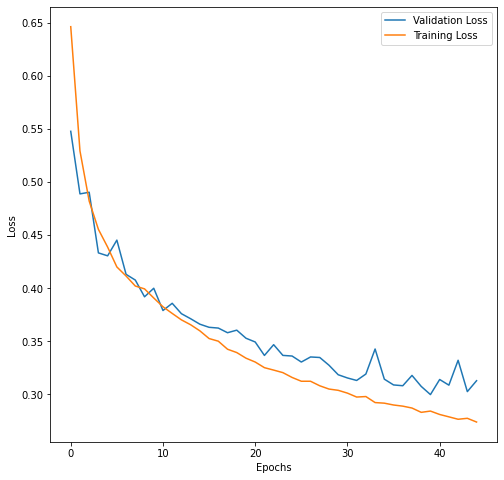

In [55]:
# plot loss history
plot_loss(history)

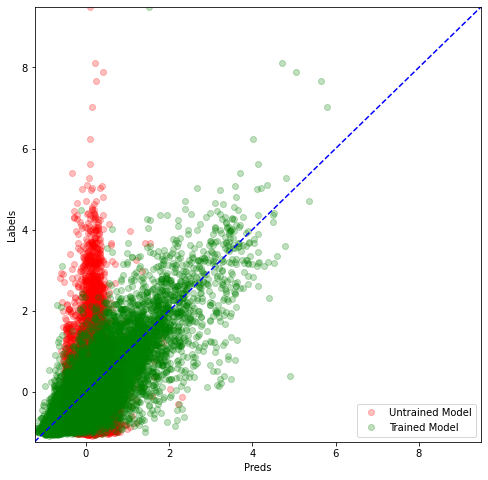

In [56]:
# compare trained and untrained models (normalized data)
preds_on_trained = model.predict(X_test)
compare_predictions(preds_on_untrained, preds_on_trained, y_test)

In [57]:
# convert normalized values 
y_mean = fulldf['pm'].mean()
y_std = fulldf['pm'].std()

def convert_label_value(pred):
    return int(pred * y_std + y_mean)

print(convert_label_value(0.33011))

128


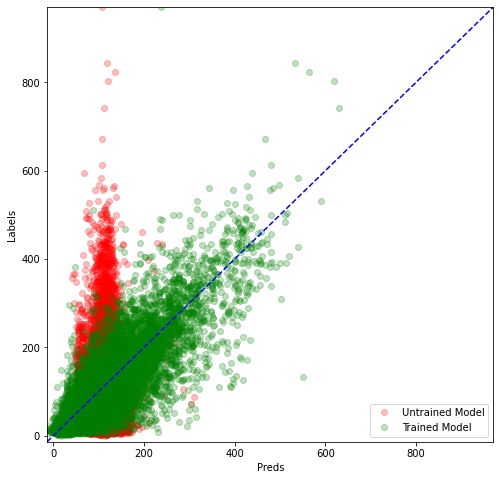

In [58]:
# plot models with de-normalized values
pm_on_untrained = [convert_label_value(y) for y in preds_on_untrained]
pm_on_trained = [convert_label_value(y) for y in preds_on_trained]
pm_y_test = [convert_label_value(y) for y in y_test]

compare_predictions(pm_on_untrained, pm_on_trained, pm_y_test)